In [3]:
# -----------------------------
# 1. Import Libraries
# -----------------------------
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os

# Check devices and TensorFlow version
print("TensorFlow version:", tf.__version__)
print("Devices:", tf.config.list_physical_devices())

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

TensorFlow version: 2.16.2
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
# -----------------------------
# 2. Load Dataset
# -----------------------------
# Dataset parameters
img_size = (150, 150)   # resize images
batch_size = 32
dataset_path = "brain_tumor_dataset"  # Updated to match your dataset location

# Load training dataset (80% of data)
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    class_names=['no', 'yes']  # Explicitly specify class names
)

# Load validation dataset (20% of data)
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    class_names=['no', 'yes']  # Explicitly specify class names
)

# Print dataset info
print(f"Number of training batches: {len(train_ds)}")
print(f"Number of validation batches: {len(val_ds)}")
print(f"Class names: {train_ds.class_names}")

# Calculate dataset sizes
train_size = len(train_ds) * batch_size
val_size = len(val_ds) * batch_size
print(f"Approximate training samples: {train_size}")
print(f"Approximate validation samples: {val_size}")

Found 253 files belonging to 2 classes.
Using 203 files for training.
Found 253 files belonging to 2 classes.
Using 50 files for validation.
Number of training batches: 7
Number of validation batches: 2
Class names: ['no', 'yes']
Approximate training samples: 224
Approximate validation samples: 64


2025-09-01 11:32:26.187328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


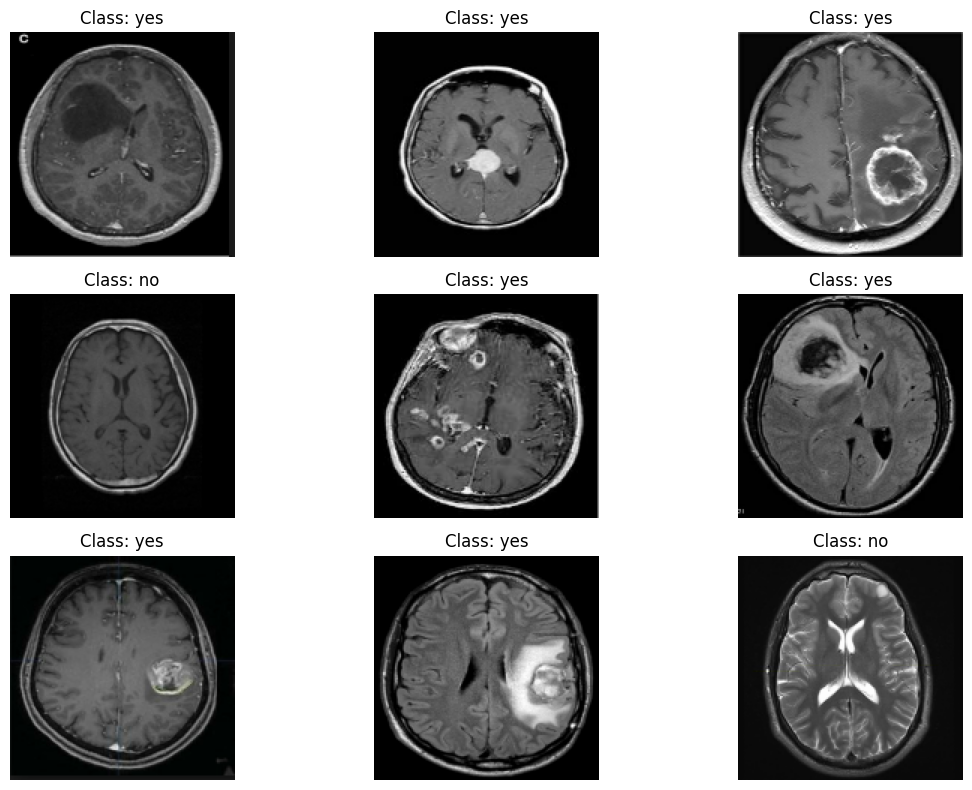

In [7]:
# -----------------------------
# 3. Visualize Sample Images
# -----------------------------
plt.figure(figsize=(12, 8))
for images, labels in train_ds.take(1):
    for i in range(min(9, len(images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        class_name = 'yes' if labels[i] == 1 else 'no'
        plt.title(f"Class: {class_name}")
        plt.axis("off")
plt.tight_layout()
plt.show()

In [8]:
# -----------------------------
# 4. Data Preprocessing
# -----------------------------
# Normalize pixel values (0–255 → 0–1)
normalization_layer = layers.Rescaling(1./255)

# Apply normalization
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("Data preprocessing completed!")

Data preprocessing completed!


In [9]:
# -----------------------------
# 5. Build CNN Model
# -----------------------------
model = models.Sequential([
    # Input layer
    layers.Input(shape=(150, 150, 3)),
    
    # First convolutional block
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    # Second convolutional block
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    # Third convolutional block
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    # Flatten and dense layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # binary classification
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# -----------------------------
# 6. Train Model
# -----------------------------
# Set up callbacks for better training
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3
    )
]

# Train the model
print("Starting training...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")

Starting training...
Epoch 1/20


2025-09-01 11:32:34.682913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.4828 - loss: 1.4197 - val_accuracy: 0.3600 - val_loss: 0.7565 - learning_rate: 0.0010
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6601 - loss: 0.6373 - val_accuracy: 0.7000 - val_loss: 0.6466 - learning_rate: 0.0010
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7438 - loss: 0.5781 - val_accuracy: 0.7400 - val_loss: 0.5689 - learning_rate: 0.0010
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7291 - loss: 0.5646 - val_accuracy: 0.6800 - val_loss: 0.5859 - learning_rate: 0.0010
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7734 - loss: 0.5187 - val_accuracy: 0.7400 - val_loss: 0.5530 - learning_rate: 0.0010
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7833 - loss: 0.4925 - val_accuracy: 0.7400 - val_loss: 0.5698 - learning_rate: 0.0010
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7931 - loss: 0.4604 - val_accuracy: 0.7400 - val_loss

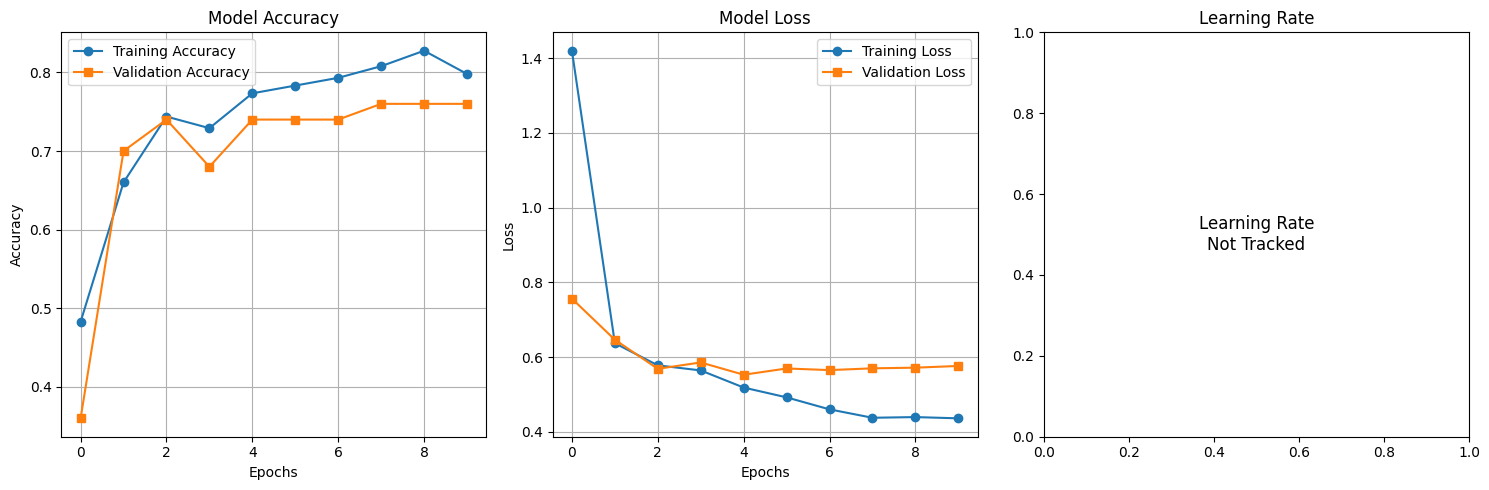

Final Training Accuracy: 0.7980
Final Validation Accuracy: 0.7600
Final Training Loss: 0.4364
Final Validation Loss: 0.5765


In [11]:
# -----------------------------
# 7. Plot Training Performance
# -----------------------------
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(15, 5))

# Plot accuracy
plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='s')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)

# Plot loss
plt.subplot(1, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='s')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)

# Plot learning rate (if available)
plt.subplot(1, 3, 3)
if 'lr' in history.history:
    lr = history.history['lr']
    plt.plot(epochs_range, lr, label='Learning Rate', marker='o')
    plt.legend()
    plt.title('Learning Rate')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.grid(True)
else:
    plt.text(0.5, 0.5, 'Learning Rate\nNot Tracked', 
             horizontalalignment='center', verticalalignment='center',
             transform=plt.gca().transAxes, fontsize=12)
    plt.title('Learning Rate')

plt.tight_layout()
plt.show()

# Print final metrics
print(f"Final Training Accuracy: {acc[-1]:.4f}")
print(f"Final Validation Accuracy: {val_acc[-1]:.4f}")
print(f"Final Training Loss: {loss[-1]:.4f}")
print(f"Final Validation Loss: {val_loss[-1]:.4f}")

Validation Accuracy: 0.7400
Validation Loss: 0.5530
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


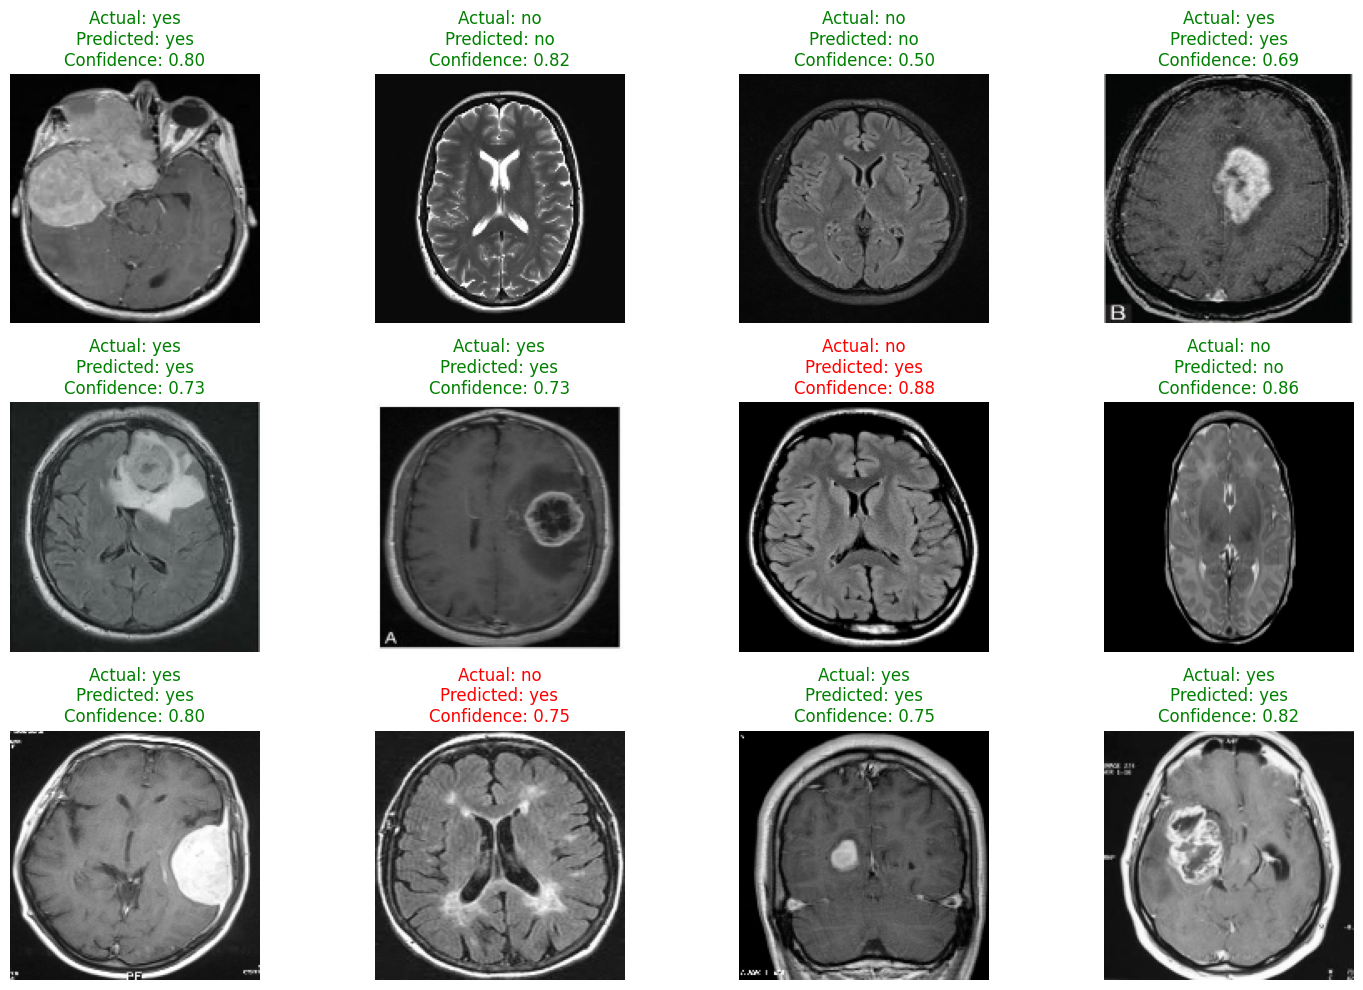

In [12]:
# -----------------------------
# 8. Model Evaluation
# -----------------------------
# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(val_ds, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

# Make predictions on a few samples
plt.figure(figsize=(15, 10))
for images, labels in val_ds.take(1):
    predictions = model.predict(images)
    
    for i in range(min(12, len(images))):
        plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy())
        
        actual_label = 'yes' if labels[i] == 1 else 'no'
        predicted_prob = predictions[i][0]
        predicted_label = 'yes' if predicted_prob > 0.5 else 'no'
        confidence = predicted_prob if predicted_prob > 0.5 else 1 - predicted_prob
        
        color = 'green' if actual_label == predicted_label else 'red'
        plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}\nConfidence: {confidence:.2f}", 
                 color=color)
        plt.axis("off")
    break

plt.tight_layout()
plt.show()

In [15]:
# -----------------------------
# 9. Save Model
# -----------------------------
# Create models directory if it doesn't exist
os.makedirs("models", exist_ok=True)

# Save the model
model_path = "models/brain_tumor_cnn.h5"
model.save(model_path)
print(f"Model saved successfully to {model_path} ✅")

# Also save in newer format
model_path_new = "models/brain_tumor_cnn.keras"
model.save(model_path_new)
print(f"Model also saved in new format to {model_path_new} ✅")

# Save model summary
with open("models/model_summary.txt", "w") as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
print("Model summary saved to models/model_summary.txt ✅")

Model saved successfully to models/brain_tumor_cnn.h5 ✅
Model also saved in new format to models/brain_tumor_cnn.keras ✅


Model summary saved to models/model_summary.txt ✅


In [19]:
# -----------------------------
# 10. Prediction Function
# -----------------------------
def predict_brain_tumor(image_path, model, img_size=(150, 150)):
    """
    Predict if an image contains a brain tumor
    
    Args:
        image_path: Path to the image file
        model: Trained model
        img_size: Size to resize the image to
    
    Returns:
        prediction: 'yes' or 'no'
        confidence: Confidence score
    """
    # Load and preprocess the image
    img = tf.keras.utils.load_img(image_path, target_size=img_size)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize
    
    # Make prediction
    prediction_prob = model.predict(img_array, verbose=0)[0][0]
    prediction = 'yes' if prediction_prob > 0.5 else 'no'
    confidence = prediction_prob if prediction_prob > 0.5 else 1 - prediction_prob
    
    return prediction, confidence

# Example usage (uncomment to test with your own images)
# prediction, confidence = predict_brain_tumor('path_to_your_image.jpg', model)
# print(f"Prediction: {prediction} (Confidence: {confidence:.2f})")

print("Prediction function created! You can now use predict_brain_tumor() to make predictions on new images.")

Prediction function created! You can now use predict_brain_tumor() to make predictions on new images.


In [20]:
# Test on a few sample images from your dataset
test_images = [
    'brain_tumor_dataset/yes/Y1.jpg',      # Should predict 'yes' (tumor)
    'brain_tumor_dataset/no/1 no.jpeg',    # Should predict 'no' (no tumor)
    'brain_tumor_dataset/yes/Y10.jpg',     # Should predict 'yes' (tumor)
    'brain_tumor_dataset/no/10 no.jpg'     # Should predict 'no' (no tumor)
]

print("🧠 Testing Brain Tumor Detection Model")
print("=" * 50)

for image_path in test_images:
    try:
        prediction, confidence = predict_brain_tumor(image_path, model)
        print(f"�� Image: {image_path.split('/')[-1]}")
        print(f"🔍 Prediction: {prediction.upper()}")
        print(f"📊 Confidence: {confidence:.2f}")
        print(f"✅ Expected: {'YES' if 'yes' in image_path else 'NO'}")
        print("-" * 30)
    except Exception as e:
        print(f"❌ Error with {image_path}: {e}")
        print("-" * 30)

🧠 Testing Brain Tumor Detection Model
�� Image: Y1.jpg
🔍 Prediction: YES
📊 Confidence: 0.72
✅ Expected: YES
------------------------------
�� Image: 1 no.jpeg
🔍 Prediction: NO
📊 Confidence: 0.69
✅ Expected: NO
------------------------------
�� Image: Y10.jpg
🔍 Prediction: YES
📊 Confidence: 0.74
✅ Expected: YES
------------------------------
�� Image: 10 no.jpg
🔍 Prediction: YES
📊 Confidence: 0.66
✅ Expected: NO
------------------------------
